In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import os
import pandas as pd
import numpy as np
import sys
import pickle
from scipy.spatial.distance import cdist
import math
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadag
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import mygene
import re

In [2]:
def load_network(network_file_list, valid_gene_list):
    
    gene_neighbor_map = {}
    
    for file_name in network_file_list:
        
        print('Load network', file_name)
        
        file_handle = open(file_name)
    
        for line in file_handle:
        
            line = line.rstrip().split()
            try:
                gene1, gene2 = line[0], line[1]
            except:
                print(line)
        
            if gene1 not in valid_gene_list or gene2 not in valid_gene_list:
                continue
        
            if gene1 not in gene_neighbor_map:
                gene_neighbor_map[gene1] = set()
            if gene2 not in gene_neighbor_map:
                gene_neighbor_map[gene2] = set()
            
            gene_neighbor_map[gene1].add(gene2)
            gene_neighbor_map[gene2].add(gene1)
            
        file_handle.close()
    
    return gene_neighbor_map
                             
def load_name_space():
        
    go_tab_map = {}
    
    file_handle = open(go_name_space_file)
    
    for line in file_handle:
        line = line.rstrip().split()
        go_tab_map[line[0]] = line[1]
        
    file_handle.close()
    
    return go_tab_map
        
def list2index(cell_line_list, cell_line2id):
    
    cell_line_idx_list = []
    
    for cell_line in cell_line_list:
        cell_line_idx_list.append(cell_line2id[cell_line])
        
    return np.asarray(cell_line_idx_list)

In [3]:
data_file = '../data/'
new_network_file = '../network/'

exp_data_file = data_file + 'Cell_line_RMA_proc_basalExp.txt'

drug_cell_line_file = data_file + 'v17_fitted_dose_response.csv'
cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
mutation_data_file = data_file + 'WES_variants.csv'
drug_target_file = data_file + 'drug_target_list'

feature_folder = 'feature/'

inbiomap_file = 'core_inbiomap.sif'
pathwaycomm_file = 'PathwayCommons9.txt'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

In [4]:
exp_df = pd.read_csv(exp_data_file, sep='\t', index_col=0)
exp_df = exp_df.T[1:]
exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
exp_df = exp_df.drop('NO_GENE_NAME',axis=1)

def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))

exp_df.index = exp_df.index.map(stripNumber)
exp_df = exp_df.groupby(level=0).first()

exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())

print(len(exp_cell_line_list), len(exp_gene_list))

exp_df

1014 17419


GENE_SYMBOLS,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00514,OR1D5,ZNF234,MYH4,LINC00526,PPY2,KRT18P55,POLRMTP1,UBL5P2,TBC1D3P5
683665,3.238273,2.982254,10.235491,4.856061,4.07887,9.116236,3.65859,6.145475,5.042464,5.438402,...,3.103752,3.724013,3.981948,2.823245,5.866047,3.095716,3.274367,3.056214,9.446305,3.530871
683667,7.780713,2.753253,9.960137,4.351073,3.71674,3.222277,8.221606,3.823474,4.756228,5.805642,...,3.175476,3.779354,4.504481,2.690651,3.34752,3.230713,3.102091,3.169188,9.81043,3.266915
684052,7.301344,2.890533,9.922489,4.125088,3.678987,3.096576,3.588391,4.809305,4.951782,5.089165,...,3.2993,3.762301,4.177345,2.499803,5.05426,3.003521,3.068187,3.135479,9.073222,3.098364
684055,8.690198,3.091473,9.992487,4.572198,3.333385,3.320793,3.159487,3.515105,5.446361,5.348338,...,3.251885,2.929491,4.702208,2.489674,5.097089,3.114744,3.119647,3.194925,9.01322,3.074187
684057,8.233101,2.824687,10.015884,4.749715,3.839433,3.142754,5.32983,3.272124,5.538055,6.428482,...,3.08175,3.226083,4.666295,2.491254,6.261573,3.031862,3.322455,2.81344,8.893197,3.266184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660036,7.797699,2.6409,9.4634,4.039697,3.854522,3.21282,3.369225,8.969264,6.660734,4.94239,...,6.654799,3.734381,4.158913,2.849266,4.772469,3.101758,3.66219,3.329809,9.491964,3.317055
1674021,7.606903,3.157319,10.153141,3.76809,3.50294,3.219493,3.353777,7.774275,6.146783,5.429215,...,8.123459,3.467924,3.862499,2.835317,3.329585,3.193906,4.15213,3.332182,8.826412,3.852447
1723793,7.24767,2.75943,10.381303,4.596494,4.101198,3.442188,4.684189,8.540689,5.46629,5.79839,...,3.122087,3.40917,3.989737,2.488525,4.011168,2.934818,3.472314,3.122506,9.534718,3.543271
1723794,6.97815,2.892534,10.203625,3.86789,3.962809,3.562039,3.198608,9.053622,5.309724,5.795402,...,3.177008,3.247534,4.005281,2.484837,4.825418,2.989489,3.139941,3.128112,10.346289,3.19236


In [5]:
maf = pd.read_csv(mutation_data_file,index_col=0).fillna(0)
mutation_df = maf.groupby(['COSMIC_ID', 'Gene']).size().unstack().fillna(0).clip(upper=1)
mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())

print(len(mutation_cell_line_list), len(mutation_gene_list))

mutation_df

1001 19100


Gene,A1BG,A1CF,A2M,A2ML1,A4D226,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,hCG_17324,hsa-mir-4763
COSMIC_ID,,,,,,,,,,,,,,,,,,,,,
683665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
683667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1660035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1660036,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
drug_paths = pd.read_csv('../data/drug_pathways.tsv', sep='\t')
drugs_legend = pd.read_csv('../data/Screened_Compounds_v2.tsv', sep='\t', index_col=0, encoding='latin-1')

drug_paths = drug_paths.drop_duplicates()
drugs_legend = drugs_legend.drop_duplicates()
filtered = drug_paths[drug_paths['Targeted process or pathway'].isin(['other', 'chromatin other'])]

drugs_list = list(filtered['Drug'])
z = []
for drug in drugs_list:
    drug_synonym = drugs_legend[drugs_legend.apply(lambda x: drug in str(x['Synonyms']), axis=1)]
    if len(drug_synonym) > 0:
        drug_name = drug_synonym['Drug Name'].iloc[0]
        if drug_name not in drugs_list:
            z.append(drug_name)

drugs_list.extend(z)

selected_drugs = drugs_legend[ ~ ( drugs_legend['Drug Name'].isin(drugs_list) ) ]
drug_file_dest = '../data/drug_target_list'
d_file = open(drug_file_dest, 'w')
selected_drugs.apply(lambda x: d_file.write(x['Drug Name']+"|"+x['Target']+"\n"), axis=1)
d_file.close()


In [7]:
file_handle = open(drug_target_file)

drug_target_map = {}
drug_target_list = []

for line in file_handle:
    
    drug, target_list_str = line.rstrip().split('|')
    drug = drug.strip()
    
    drug_target_map[drug] = []
    
    if ',' not in target_list_str:
        drug_target_map[drug].append(target_list_str.strip())
        drug_target_list.append(target_list_str.strip())
    else:
        target_list = target_list_str.split(',')
        for target in target_list:
            drug_target_map[drug].append(target.strip())
            drug_target_list.append(target.strip())

print(len(drug_target_list))
print(drug_target_map)

367
{'Erlotinib': ['EGFR'], 'Rapamycin': ['MTORC1'], 'Sunitinib': ['PDGFR', 'KIT', 'VEGFR', 'FLT3', 'RET', 'CSF1R'], 'PHA-665752': ['MET'], 'MG-132': ['Proteasome', 'CAPN1'], 'Paclitaxel': ['Microtubule stabiliser'], 'Cyclopamine': ['SMO'], 'AZ628': ['BRAF'], 'Sorafenib': ['PDGFR', 'KIT', 'VEGFR', 'RAF'], 'Tozasertib': ['AURKA', 'AURKB', 'AURKC', 'others'], 'Imatinib': ['ABL', 'KIT', 'PDGFR'], 'NVP-TAE684': ['ALK'], 'Crizotinib': ['MET', 'ALK', 'ROS1'], 'Saracatinib': ['ABL', 'SRC'], 'S-Trityl-L-cysteine': ['KIF11'], 'Z-LLNle-CHO': ['gamma-secretase'], 'Dasatinib': ['ABL', 'SRC', 'Ephrins', 'PDGFR', 'KIT'], 'GNF-2': ['BCR-ABL'], 'CGP-60474': ['CDK1', 'CDK2', 'CDK5', 'CDK7', 'CDK9', 'PKC'], 'CGP-082996': ['CDK4'], 'A-770041': ['LCK', 'FYN'], 'WH-4-023': ['SRC', 'LCK'], 'WZ-1-84': ['BMX'], 'BI-2536': ['PLK1', 'PLK2', 'PLK3'], 'BMS-536924': ['IGF1R', 'IR'], 'BMS-509744': ['ITK'], 'CMK': ['RSK2'], 'Pyrimethamine': ['Dihydrofolate reductase (DHFR)'], 'JW-7-52-1': ['MTOR'], 'A-443654': ['AKT

In [8]:
drugs_legend = pd.read_csv('../data/Screened_Compounds_v2.tsv', sep='\t', index_col=0, encoding='latin-1')

print(drugs_legend['Target Pathway'].value_counts())

drug2id_mapping = {}

for index in list(drugs_legend.index) :
    drug_name = drugs_legend.loc[index,'Drug Name']
    drug2id_mapping[ drug_name ] = index

drug2id_mapping

Target Pathway
Other                            45
Other, kinases                   31
PI3K/MTOR signaling              24
RTK signaling                    21
ERK MAPK signaling               18
                                 ..
Hormone-related                   3
Metabolism                        3
Chromatin histone methylation     3
p53 pathway                       3
ABL signaling                     2
Name: count, Length: 23, dtype: int64


{'Erlotinib': 1,
 'Rapamycin': 3,
 'Sunitinib': 5,
 'PHA-665752': 6,
 'MG-132': 9,
 'Paclitaxel': 11,
 'Cyclopamine': 17,
 'AZ628': 29,
 'Sorafenib': 30,
 'Tozasertib': 32,
 'Imatinib': 34,
 'NVP-TAE684': 35,
 'Crizotinib': 37,
 'Saracatinib': 38,
 'S-Trityl-L-cysteine': 41,
 'Z-LLNle-CHO': 45,
 'Dasatinib': 51,
 'GNF-2': 52,
 'CGP-60474': 53,
 'CGP-082996': 54,
 'A-770041': 55,
 'WH-4-023': 56,
 'WZ-1-84': 59,
 'BI-2536': 60,
 'BMS-536924': 1091,
 'BMS-509744': 63,
 'CMK': 64,
 'Pyrimethamine': 71,
 'JW-7-52-1': 83,
 'A-443654': 86,
 'GW843682X': 87,
 'Entinostat': 88,
 'Parthenolide': 89,
 'GSK319347A': 91,
 'TGX221': 94,
 'Bortezomib': 104,
 'XMD8-85': 106,
 'Seliciclib': 110,
 'Salubrinal': 111,
 'Lapatinib': 119,
 'GSK269962A': 1192,
 'Doxorubicin': 133,
 'Etoposide': 134,
 'Gemcitabine': 135,
 'Mitomycin-C': 136,
 'Vinorelbine': 140,
 'NSC-87877': 147,
 'Bicalutamide': 1502,
 'QS11': 151,
 'CP466722': 152,
 'Midostaurin': 153,
 'CHIR-99021': 1241,
 'Ponatinib': 155,
 'AZD6482': 1

In [9]:
valid_gene_list = list(set(drug_target_list) | set(exp_gene_list) | set(mutation_gene_list))

network_list = [new_network_file+inbiomap_file, new_network_file+pathwaycomm_file]
gene_neighbor_map = load_network(network_list, valid_gene_list)

Load network ../network/core_inbiomap.sif
Load network ../network/PathwayCommons9.txt
[]


In [10]:
gene_name_df = pd.read_csv(data_file + 'HUGO_protein-coding_gene.txt', index_col=25, sep='\t')

/var/folders/yn/zfc818ss29b0byy4rjx8vsgw0000gp/T/ipykernel_47181/645273414.py:1: DtypeWarning: Columns (31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_name_df = pd.read_csv(data_file + 'HUGO_protein-coding_gene.txt', index_col=25, sep='\t')


In [11]:
gene_name_map = {}

for uniprot_gene in gene_name_df.index:
    #print uniprot_gene
    if isinstance(uniprot_gene, type('aaa')) == False:
        continue
    
    if isinstance(gene_name_df.loc[uniprot_gene, 'symbol'], type('aaa')) == False:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]
    else:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol']

/var/folders/yn/zfc818ss29b0byy4rjx8vsgw0000gp/T/ipykernel_47181/1317027256.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]


In [12]:
corum_df = pd.read_csv(new_network_file + 'allComplexes.txt', index_col=0, sep='\t')

uniprot_gene_set = set()

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
        
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    for gene in complex_list:
        uniprot_gene_set.add(gene)

print(len(uniprot_gene_set), 'genes')

query_gene_set = []

for gene in uniprot_gene_set:
    if gene not in gene_name_map:
        query_gene_set.append(gene)
    
print('Need to query', len(query_gene_set))

query_gene_list = list(query_gene_set)

mg = mygene.MyGeneInfo()
out = mg.querymany(query_gene_list, scopes='uniprot', fields='symbol', species='human')

not_found_gene_list = []

for i, gene in enumerate(query_gene_list):
    if 'notfound' in out[i]:
        not_found_gene_list.append(gene)
    else:
        gene_name_map[gene] = out[i]['symbol']
        
print(len(not_found_gene_list), 'symbol name not found', len(gene_name_map))

4499 genes
Need to query 119


99 input query terms found no hit:	['Q13791', 'Q6ZUT3-2', 'Q8WXF7-1', 'Q6PIL6-4', 'Q01105-1', 'P01871', 'P16471-4', 'P04637-2', 'P04637


99 symbol name not found 19148


In [13]:
corum_df = pd.read_csv(new_network_file + 'allComplexes.txt', index_col=0, sep="\t")

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
    
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    complex_symbol_list = []
    
    for gene in complex_list:
        if gene in gene_name_map:
            complex_symbol_list.append( gene_name_map[gene] )

    for gene1, gene2 in itertools.combinations(complex_symbol_list,2):
        
        if gene1 not in gene_neighbor_map:
            gene_neighbor_map[gene1] = set()
        if gene2 not in gene_neighbor_map:
            gene_neighbor_map[gene2] = set()
        
        gene_neighbor_map[gene1].add(gene2)
        gene_neighbor_map[gene2].add(gene1)

In [14]:
gene_exp_neighbor_map = {}
exp_matrix = exp_df.values

P = 1 - cdist(np.transpose(exp_matrix), np.transpose(exp_matrix),'correlation')

for i in range(len(exp_gene_list)):
    
    gene1 = exp_gene_list[i]
    gene_exp_neighbor_map[gene1] = set()
    
    for j in range(len(exp_gene_list)):
        
        gene2 = exp_gene_list[j]
        
        if math.fabs(P[i, j]) > 0.4:
            gene_exp_neighbor_map[gene1].add(gene2)
            
    if gene1 not in gene_exp_neighbor_map[gene1]:
        print(gene1, 'not in itself?', P[i,i])

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

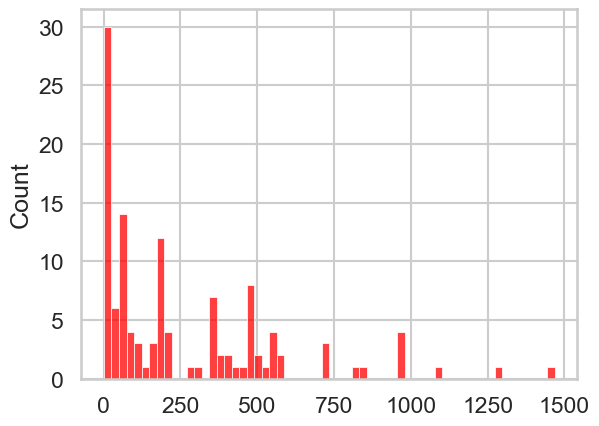

In [19]:
drug_feature_list = []
drug_neighbor_map = {}
selected_drug_list = []

for drug, target_list in drug_target_map.items():
    
    drug_neighbor_map[drug] = set()
    
    for gene in target_list:
        
        if gene not in gene_exp_neighbor_map and gene not in gene_neighbor_map:
            continue
    
        if gene in gene_exp_neighbor_map:
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_exp_neighbor_map[gene]
            
        if gene in gene_neighbor_map:
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_neighbor_map[gene]
    
    if len(drug_neighbor_map[drug]) != 0:
        selected_drug_list.append(drug)
        drug_feature_list.append( len(drug_neighbor_map[drug]) )

sns.set_style("whitegrid")
sns.set_context("talk")
sns.histplot(drug_feature_list,color='r',bins=60,kde=False)

In [21]:
drugs = pd.read_csv(drug_cell_line_file,index_col=2)
drugs_cell_line_list = list(drugs.index.unique())
print(len(drugs_cell_line_list))
drugs

#cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == 1026]
#cell_line_drug_matrix.loc[[924100,910924],'LN_IC50'].values

#cell_line_drug_matrix.loc[ [909758, 924247, 924107],'DRUG_ID' ]

1074


,DATASET_VERSION,IC50_RESULTS_ID,DRUG_ID,MAX_CONC_MICROMOLAR,LN_IC50,AUC,RMSE
COSMIC_ID,,,,,,,
924100,17,335,1026,1.00,0.717722,0.899410,0.105665
924100,17,336,1028,2.00,2.664100,0.957206,0.178243
924100,17,337,1029,2.00,3.336828,0.973893,0.079845
924100,17,338,1030,10.00,5.164909,0.977844,0.094228
924100,17,339,1031,0.20,-4.325309,0.508180,0.090478
...,...,...,...,...,...,...,...
909907,17,226218,1053,4.00,1.282224,0.809102,0.157131
909907,17,226219,1054,4.00,5.480756,0.982976,0.027090
909907,17,226220,1057,0.25,-0.138981,0.904217,0.031997


In [22]:
cell_line_list = list(set(drugs_cell_line_list)&set(exp_cell_line_list)&set(mutation_cell_line_list) )
print(len(cell_line_list))

962


In [25]:
cell_line_legend = pd.read_csv(cell_line_detail_file, sep='\t', index_col=1)
#print cell_line_legend

tissue_map = {}

for cell_line in cell_line_list:
    
    tissue = cell_line_legend.loc[cell_line,'GDSC Tissue descriptor 2']
    
    if tissue not in tissue_map:
        tissue_map[tissue] = []
        
    tissue_map[tissue].append(cell_line)

large_tissue_number = 0
for tissue, cell_line in tissue_map.items():
    
    if len(cell_line) >= 15:
        large_tissue_number += 1
    
    print(tissue, len(cell_line))

print('How many tissues', len(tissue_map))
print('Large tissues', large_tissue_number)

'''
file_handle = open(data_file + "sanger_tissue_cell_line_list.pkl","wb")
pickle.dump(tissue_map,file_handle)
file_handle.close()
'''

Burkitt_lymphoma 13
lymphoid_neoplasm other 10
glioma 52
lymphoblastic_leukemia 12
anaplastic_large_cell_lymphoma 3
B_cell_lymphoma 32
acute_myeloid_leukaemia 26
stomach 28
myeloma 13
rhabdomyosarcoma 9
pancreas 32
ewings_sarcoma 21
large_intestine 48
chondrosarcoma 5
lung_small_cell_carcinoma 60
soft_tissue_other 9
kidney 32
leukemia 3
chronic_myeloid_leukaemia 10
Bladder 19
neuroblastoma 29
oesophagus 35
Hodgkin_lymphoma 9
head and neck 44
lung_NSCLC_adenocarcinoma 66
lung_NSCLC_squamous_cell_carcinoma 15
ovary 41
breast 50
cervix 14
lung_NSCLC_large cell 13
endometrium 11
thyroid 15
B_cell_leukemia 12
lymphoblastic_T_cell_leukaemia 8
melanoma 52
osteosarcoma 10
lung_NSCLC_not specified 11
bone_other 2
liver 17
haematopoietic_neoplasm other 6
adrenal_gland 1
fibrosarcoma 3
urogenital_system_other 4
prostate 7
biliary_tract 5
lung_NSCLC_carcinoid 4
mesothelioma 21
T_cell_leukemia 4
uterus 2
hairy_cell_leukaemia 3
testis 2
Lung_other 1
skin_other 3
medulloblastoma 4
digestive_system_ot

'\nfile_handle = open(data_file + "sanger_tissue_cell_line_list.pkl","wb")\npickle.dump(tissue_map,file_handle)\nfile_handle.close()\n'

In [31]:
new_data_file = ''

print(mutation_df.shape, exp_df.shape)
exp_stdev = np.std(exp_df.values)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

print(np.sum(exp_stdev > exp_perc), np.sum(mut_sum > 5))#, np.sum(cnv_stdev > cnv_perc)

#new_exp_df = exp_df.loc[ cell_line_list, list(filtered_exp_gene_list) ]
#new_mutation_df = mutation_df.loc[ cell_line_list, list(filtered_mut_gene_list) ]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

#cell_line2id = dict(zip(cell_line_list, range(len(cell_line_list))))

rename_selected_drug_list = []

for drug in selected_drug_list:
    
#     if drug != 'Nutlin-3a (-)':
#         continue
    
    if drug not in drug2id_mapping:
        print('drug name wrong', drug)
        sys.exit(1)
    
    cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == drug2id_mapping[drug]]
    
    #print cell_line_drug_matrix
    
    feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
    feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
    
    if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
        continue
    
    feature_description = []
    
    drug_tissue_map = {}
    
    drug = drug.replace(' ','_')
    
    rename_selected_drug_list.append(drug)
    
    print(drug)
    if drug == 'Nutlin-3a_(-)':
        drug = 'Nutlin-3a'
    
    drug_folder = 'drug_feature/' + drug + '/'
    if not os.path.exists(drug_folder):
        os.makedirs(drug_folder)
        
    print('Generate features', drug)
    
    for tissue, tissue_cell_line_list in tissue_map.items():
        
        drug_specific_cell_line = set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )
        
        drug_tissue_map[tissue] = drug_specific_cell_line
        
        feature_list = []
        
        if len(feature_exp_gene_list) != 0:
            feature_list.append( new_exp_df.loc[ list(drug_specific_cell_line), feature_exp_gene_list ].values )
            for gene in feature_exp_gene_list:
                feature_description.append(gene+'_expression')
        
        if len(feature_mut_gene_list) != 0:
            feature_list.append( mutation_df.loc[ list(drug_specific_cell_line), feature_mut_gene_list ].values )
            for gene in feature_mut_gene_list:
                feature_description.append(gene+'_mutation')
            
        feature = np.concatenate(feature_list, axis=1)
        
        label = cell_line_drug_matrix.loc[ list(drug_specific_cell_line),'LN_IC50'].values
        
        #label = new_crispr_df.loc[ tissue_cell_line_list, label_gene ].values
    
        print(feature.shape, label.shape)
     
        np.save(drug_folder + tissue + '_' + drug + '_feature.npy', feature )
        np.save(drug_folder + tissue + '_' + drug + '_label.npy', label)
        np.save(drug_folder + tissue + '_feature_description.npy', np.asarray(feature_description))
        
    file_handle = open(new_data_file + drug+'_tissue_cell_line_list.pkl',"wb")
    pickle.dump(drug_tissue_map,file_handle)
    file_handle.close()
    
file_handle = open('rename_selected_drug_list', 'w')
for drug in rename_selected_drug_list:
    file_handle.writelines(drug+ '\n')
file_handle.close()


(1001, 19100) (1014, 17419)
0 16794
Erlotinib
Generate features Erlotinib
(13, 414) (13,)
(10, 414) (10,)
(25, 414) (25,)
(11, 414) (11,)
(3, 414) (3,)
(25, 414) (25,)
(25, 414) (25,)
(9, 414) (9,)
(7, 414) (7,)
(2, 414) (2,)
(2, 414) (2,)
(17, 414) (17,)
(15, 414) (15,)
(0, 414) (0,)
(36, 414) (36,)
(4, 414) (4,)
(8, 414) (8,)
(1, 414) (1,)
(9, 414) (9,)
(2, 414) (2,)
(22, 414) (22,)
(8, 414) (8,)
(9, 414) (9,)
(5, 414) (5,)
(11, 414) (11,)
(2, 414) (2,)
(4, 414) (4,)
(12, 414) (12,)
(0, 414) (0,)
(2, 414) (2,)
(2, 414) (2,)
(2, 414) (2,)
(7, 414) (7,)
(4, 414) (4,)
(16, 414) (16,)
(1, 414) (1,)
(2, 414) (2,)
(1, 414) (1,)
(0, 414) (0,)
(5, 414) (5,)
(0, 414) (0,)
(1, 414) (1,)
(2, 414) (2,)
(2, 414) (2,)
(2, 414) (2,)
(1, 414) (1,)
(2, 414) (2,)
(3, 414) (3,)
(0, 414) (0,)
(3, 414) (3,)
(2, 414) (2,)
(0, 414) (0,)
(2, 414) (2,)
(2, 414) (2,)
(1, 414) (1,)
Sunitinib
Generate features Sunitinib
(13, 189) (13,)
(10, 189) (10,)
(23, 189) (23,)
(12, 189) (12,)
(3, 189) (3,)
(23, 189) (23,

In [40]:
len(drug_tissue_map['breast'])

48

In [44]:
import pickle

In [45]:
cell_line_loc = '../cell_line_lists/'

In [46]:
with open(cell_line_loc + 'KU-55933_tissue_cell_line_list.pkl', 'rb') as f: 
    tmap= pickle.load(f)

In [47]:
tmap.keys()

dict_keys(['Burkitt_lymphoma', 'lymphoid_neoplasm other', 'glioma', 'lymphoblastic_leukemia', 'anaplastic_large_cell_lymphoma', 'B_cell_lymphoma', 'acute_myeloid_leukaemia', 'stomach', 'myeloma', 'rhabdomyosarcoma', 'pancreas', 'ewings_sarcoma', 'large_intestine', 'chondrosarcoma', 'lung_small_cell_carcinoma', 'soft_tissue_other', 'kidney', 'leukemia', 'chronic_myeloid_leukaemia', 'Bladder', 'neuroblastoma', 'oesophagus', 'Hodgkin_lymphoma', 'head and neck', 'lung_NSCLC_adenocarcinoma', 'lung_NSCLC_squamous_cell_carcinoma', 'ovary', 'breast', 'cervix', 'lung_NSCLC_large cell', 'endometrium', 'thyroid', 'B_cell_leukemia', 'lymphoblastic_T_cell_leukaemia', 'melanoma', 'osteosarcoma', 'lung_NSCLC_not specified', 'bone_other', 'liver', 'haematopoietic_neoplasm other', 'adrenal_gland', 'fibrosarcoma', 'urogenital_system_other', 'prostate', 'biliary_tract', 'lung_NSCLC_carcinoid', 'mesothelioma', 'T_cell_leukemia', 'uterus', 'hairy_cell_leukaemia', 'testis', 'Lung_other', 'skin_other', 'medu

In [48]:
len(tmap['lung'])

KeyError: 'lung'

In [50]:
f = np.load('./drug_feature/KU-55933/lung_KU-55933_feature.npy')

In [51]:
f.shape

(137, 1502)